# DSCI 619: Deep Learning
## Project 6
Symphony Hopkins

### Introduction

We are data scientists in an e-commerce company. We were given a Women’s Clothing E-Commerce dataset revolving around the reviews written by customers. This dataset contains the following columns:

+ Clothing ID
+ Age
+ Title
+ Review Text
+ Rating
+ Recommended IND
+ Positive Feedback Count
+ Division Name
+ Department Name
+ Class Name

Our objective is to create a Recurrent Neural Network (RNN) model to forecast the **Recommended IND** based on **Reviews**, a new column concatenated from the other features. Then, we will evaluate the model's performance to determine whether we will recommend this model to the e-commerce company.

Data Source: [Women's E-Commerce Clothing Reviews](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

###1.Load the data, Womens Clothing E-Commerce Reviews.csv Download Womens Clothing E-Commerce Reviews.csv, into memory.

We will begin by connect the Google Drive and loading the dataset into the memory.

In [1]:
#connecting to google drive
from google.colab import drive 
drive.mount('/content/gdrive')

#importing library
import pandas as pd

#loading data
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Topic 6/Womens Clothing E-Commerce Reviews.csv')
df.head()

Mounted at /content/gdrive


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Let's check the shape of the dataframe.

In [2]:
#checking shape
df.shape

(23486, 11)

It's good practice to check the data types so we will do so.

In [3]:
#checking data types
df.dtypes

Unnamed: 0                  int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

Now we will check for missing values.

In [4]:
#checking for missing values
df.isnull().sum(axis = 0)

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

As we can see, we have missing data in the **Title, Review Text, Division Name, Department Name, and Class Name** columns. We will deal with this issue when we concatenate the columns in the next step.

###2.Please concatenate the Title, Review Text, Division Name, Department Name, and Class Name as a new feature of Reviews.


Next, we will concatenate the Title, Review Text, Division Name, Department Name, and Class Name into one new feature column called **Reviews.** During this step, we will remove the missing values ('NaN') because they won't help us in forecasting the Recommended IND.

In [5]:
#concatenating columns
review_cols = ['Title', 
               'Review Text', 
               'Division Name', 
               'Department Name',
               'Class Name']
#removing missing values using .fillna("")
df['Reviews'] = df[review_cols].fillna("").apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

Let's check if it worked.

In [6]:
#checking data frame for new Reviews column
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Reviews
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...


###3.Please clean the new feature of Reviews using regular expressions.


Next, we will will clean the new feature column, Reviews, using regular expressions. This process will include...
+ Remove all special characters, punctuation and spaces
+ Remove all words with length <=2


In [7]:
#importing library
import re #regular expression for handling texts very efficiently

#cleaning the Reviews column using regular expressions
#removing punctuation and spaces; replacing special characters,<br /> in the file
df['Reviews'] = df['Reviews'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))
df['Reviews'] = df['Reviews'].apply(lambda x: re.sub(r"<br />", " ", x))
# removing words with a length less than or equal to 2
df['Reviews'] = df['Reviews'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', '', x))

Now, let's check the Reviews column.

In [8]:
df['Reviews'].head()

0     Absolutely wonderful silky and sexy and comfo...
1     Love this dress   sooo pretty  happened  find...
2    Some major design flaws  had such high hopes f...
3     favorite buy  love love love this jumpsuit   ...
4    Flattering shirt This shirt  very flattering  ...
Name: Reviews, dtype: object

###4.Build an RNN model to forecast the Recommended IND based on Reviews using TensorFlow.


To create the RNN model, we need to split the data into training and test data sets. We will perform an 80-20 split.

In [11]:
#importing library
from sklearn.model_selection import train_test_split

#performing train-test split
X = df['Reviews'].values
y = df['Recommended IND'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

#printing shape
print(f'X_train size={X_train.shape}; X_test size  ={X_test.shape}')

X_train size=(18788,); X_test size  =(4698,)


Next, we will convert the text to numerical values using TextVectorization.

In [12]:
#importing library
import tensorflow as tf
import numpy as np

#specifying the vocab size
VOCAB_SIZE = 1000
#performing textvectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

#fitting the state of the preprocessing layer to the dataset.
encoder.adapt(X_train)

Now, we will build the RNN model with the following architecture:
+ Layer 1: Embedding Layer
+ Layer 2: GRU Layer
+ Layer 3: LSTM Layer
+ Layer 4-6: Classification Layers (w/128, 64, 1 Neurons Respectively)

In [13]:
#building RNN model
model = tf.keras.Sequential([
    #performing textvectorization which converts the raw texts to indices/integers
    encoder, 
    #embedding layer to convert the indices to numerical vectors
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        #using masking to handle the variable sequence lengths
        mask_zero=True),
    #GRU layer; the default recurrent_activation = sigmoid
    tf.keras.layers.GRU(256, return_sequences=True),
    #LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    #classification layer 1
    tf.keras.layers.Dense(128, activation='relu'),
    #classification layer 2
    tf.keras.layers.Dense(64, activation='relu'),
    #classification layer 3; must be equal to 1 since this is the output layer
    tf.keras.layers.Dense(1, activation=None)
])

Let's look at the model summary.

In [14]:
#summarizing model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1050624   
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8

We will implement early stopping since we have 1,435,905 parameters. The training will stop if the validation accuracy does not improve for 3 epochs.

In [15]:
#adding early stopping; if the validation accuracy does not improve for 3 epochs, we will stop training
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)

Next, let's configure the model. We will use the **adam** optimizer. We will also use **SparseCategoricalCrossentropy** since the Recommended IND column is encoded as integers (0 = Not Recommended, 1 = Recommended). Also, since we set the **activation=None**, we have to set **from_logits=True**. We will evaluate the model on it's accuracy.


In [16]:
#configuring the model; since activation=None we must put from_logits=True
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy']) # we will evaluate the model using accuracy

Finally, we can train the model.


In [19]:
%%time
#training the model and storing the history in a variable to plot later
#we will make the number of epochs short since training models for image classification can run for a long time
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=10, #this can be time consuming so we will only run this for 10 epochs
                    validation_data=(X_test,y_test), 
                    callbacks=[callback], 
                    verbose = 1)

Epoch 1/10
588/588 [==============================] - 998s 2s/step - loss: 0.2982 - accuracy: 0.8667 - val_loss: 0.2294 - val_accuracy: 0.9053
Epoch 2/10
588/588 [==============================] - 888s 2s/step - loss: 0.2097 - accuracy: 0.9083 - val_loss: 0.2122 - val_accuracy: 0.9061
Epoch 3/10
588/588 [==============================] - 894s 2s/step - loss: 0.2005 - accuracy: 0.9147 - val_loss: 0.2178 - val_accuracy: 0.9014
Epoch 4/10
588/588 [==============================] - 891s 2s/step - loss: 0.1918 - accuracy: 0.9171 - val_loss: 0.2115 - val_accuracy: 0.9044
Epoch 5/10
588/588 [==============================] - 911s 2s/step - loss: 0.1879 - accuracy: 0.9202 - val_loss: 0.2116 - val_accuracy: 0.9053
CPU times: user 1h 50min 31s, sys: 3min 47s, total: 1h 54min 18s
Wall time: 1h 16min 22s


Now, let's look at the model architecture.

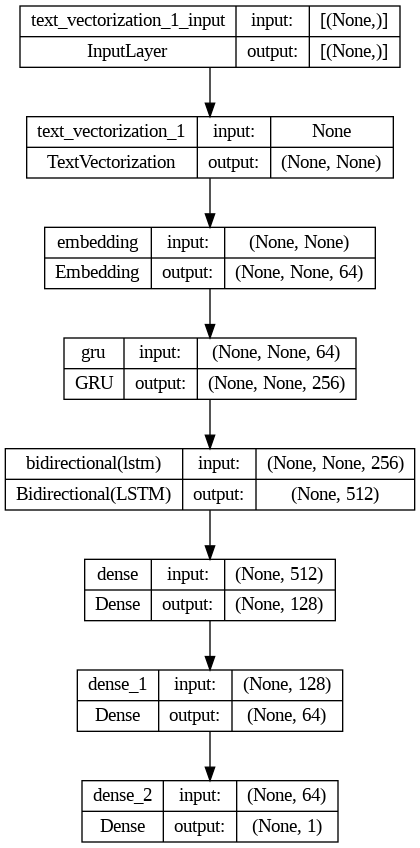

In [20]:
#displaying model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

###5.Evaluate the model and check the model fit. Do you recommend this model? Please justify your answer.

Let's evaluate the model by visualizing history.

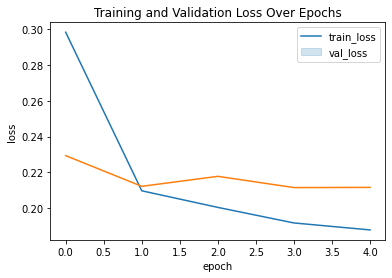

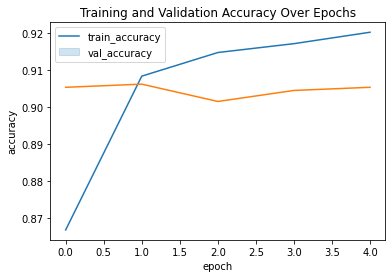

In [21]:
#importing libraries
import seaborn as sns
import matplotlib.pyplot as plt

#visualizing training history
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#plotting train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#plotting validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#adding legends
plt.legend(labels=['train_loss', 'val_loss'])
plt.title('Training and Validation Loss Over Epochs')
plt.show()

#plotting training accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation accuracy
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#adding legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()

Looking at the graphs, we can see that model has low training and validation losses, and high training and validation accuracies. It appears that the model is performing well, but let's also evaluate the model on the test dataset. We will do so by forecasting the Recommended IND labels, and then creating a confusion matrix and classification report.

In [27]:
#importing libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#the cutoff probability is 50%
y_pred = (model.predict(X_test)> 0.5).astype(int)

#creating confusion matrix
print(confusion_matrix(y_test, y_pred))

#forecasting the Recommended IND labels
#we need to convert 0 and 1 back to words so that 0 = Not Recommended and 1 = Recommended for easier readability
#printing a classification report
label_names = ['Not Recommended', 'Recommended']
print(classification_report(y_test, y_pred, target_names=label_names))

147/147 [==============================] - 49s 332ms/step
[[ 658  177]
 [ 268 3595]]
                 precision    recall  f1-score   support

Not Recommended       0.71      0.79      0.75       835
    Recommended       0.95      0.93      0.94      3863

       accuracy                           0.91      4698
      macro avg       0.83      0.86      0.84      4698
   weighted avg       0.91      0.91      0.91      4698



The classification report shows that the model is better at classifying "Not Recommended" (f1-score=0.75) than "Recommended" (f1-score=0.94). The model's accuracy is over 80%. Overall, it is a decent model, so we would recommend it to the e-commerce company; however, it could be improved so that it's better at classifying "Not Recommended" labels. 